# Problem Set 5: Probabilistic Models

This assignment requires a working IPython Notebook installation, which you should already have. If not, please refer to the instructions in the previous problem sets.

Only PDF files are accepted for submission. To print this notebook to a pdf file, you can go to "File" -> "Download as" -> "PDF via LaTex(.pdf)" or simply use "print" in browser.

**Total:** 100 points (+20 points bonus).

# 1 Linear Discriminant Analysis (LDA) [50 pts + 10pts bonus]
In this exercise, we build a linear discriminant analysis (LDA) classifier for the problem of predicting whether a student gets admitted into a university. 

LDA is a generative model for classification. Given a training dataset of positive and negative features $(x, y)$ with $y \in {0, 1}$, LDA models the data $x$ as generated from class-conditional Gaussians: $ P(x, y) = P(x|y)P(y)$, where $P(y = 1) = \pi$ and $P(x|y=j) = N(x;\mu^j,\Sigma)$. Here means $\mu^j$ are class-dependent but the covariance matrix $\Sigma$ is class-independent (the same for all classes). 

A novel feature $x$ is classified as a positive if $P(y = 1|x) > P(y = 0|x)$, which is equivalent to $a(x)\gt0$, where the linear classifier $a(x) = w^Tx+w_0$ has weights given by $w = \Sigma^{-1}(\mu^1-\mu^0)$.

In practice, and in this assignment, we use $a(x)\gt$ some threshold, or equivalently, $w^Tx>T$ for some constant $T$. The specific threshold can be determined on a validation dataset or via cross-validation.

As we saw in lecture, LDA and logistic regression can be expressed in the same form

$$P(y=1|x) = \frac{1}{1+e^{-\theta^Tx}}.$$

However, they generally produce different solutions for the parameter theta.

### 1.1 Derivation of LDA [20 pts]

Show that the log-odds decision function a(x) for LDA

$$a(x) = \ln \frac{p(x|y=1)p(y=1)}{p(x|y=0)p(y=0)}$$

is linear in $x$, that is, we can express $a(x)=w^Tx + w_0$ for some $w,w_0$. Show all your steps. 


**Answer:**

According to LDA, it has linear decision boundaries:
$$
p(Y = k | X = x) = \frac{C \pi_k}{(2\pi)^{p/2}|\Sigma|^{1/2}} exp[-\frac{1}{2}(x-\mu_k)^T \Sigma^{-1} (x-\mu_k)]
$$
,where C is a constant.
By taking the log and absorbing everything that does not depend on k:

\begin{align*}
log\ p(Y = k | X = x) &= log C' + log \pi_k - \frac{1}{2}(x-\mu_k)^T \Sigma^{-1} (x-\mu_k) \\
&=  log C' + log \pi_k - \frac{1}{2}[x^T\Sigma^{-1}x - \mu_k^T\Sigma^{-1}\mu_k] + x^T\Sigma^{-1}\mu_k \\
&= C'' + log \pi_k - \frac{1}{2}\mu_k^T\Sigma^{-1}\mu_k + x^T\Sigma^{-1}\mu_k
\end{align*}
,where C' and C'' are components that are irrelevant with k.

Therefore, the objective function is:
$$
\delta_k (x) = log \pi - \frac{1}{2}\mu_k^T\Sigma^{-1}\mu_k + x^T\Sigma^{-1}\mu_k
$$

And the decision boundary betweem category k and l can be written as:
$$
log (\frac{\pi_k}{\pi_l}) - \frac{1}{2} (\mu_k + \mu_l)^T \Sigma^{-1} (\mu_k - \mu_l) + x^T\Sigma^{-1} (\mu_k - \mu_l) = 0
$$

Given that $P(y = 1) = \pi$ and $P(x|y=j) = N(x;\mu^j,\Sigma)$, the class-conditional density can be written as:
$$
p(x | y = 1) = \frac{1}{(2\pi)^{p/2} |\Sigma| ^ {1/2}} exp[\frac{1}{2}(x-\mu^1)^T \Sigma^{-1}(x - \mu^1)] \\
p(x | y = 0) = \frac{1}{(2(1-\pi))^{p/2} |\Sigma| ^ {1/2}} exp[\frac{1}{2}(x-\mu^0)^T \Sigma^{-1}(x - \mu^0)]
$$

Therefore, we can express the a(x) as:

\begin{align*}
a(x) &= \ln \frac{p(x|y=1)p(y=1)}{p(x|y=0)p(y=0)} \\
&= ln \{ \frac{\frac{1}{(2\pi)^{p/2} |\Sigma| ^ {1/2}} exp[\frac{1}{2}(x-\mu^1)^T \Sigma^{-1}(x - \mu^1)] \pi}{\frac{1}{(2(1-\pi))^{p/2} |\Sigma| ^ {1/2}} exp[\frac{1}{2}(x-\mu^0)^T \Sigma^{-1}(x - \mu^0)] (1-\pi)} \} \\
&= -\frac{1}{2} (x - \mu^1)^T \Sigma^{-1} (x - \mu^1) + \frac{1}{2} (x - \mu^0)^T \Sigma^{-1} (x - \mu^0) + const\\
&= -\frac{1}{2} [-2x^T\Sigma^{-1}\mu^1 + 2x^T\Sigma^{-1}\mu^0 + (\mu^1)^T\Sigma^{-1}\mu^1 - (\mu^0)^T\Sigma^{-1}\mu^0] + const \\
&= x^T\Sigma^{-1}(\mu^1 - \mu^0) + const
\end{align*}

Therefore, a(x) is linear in x and can be expressed as $a(x)=w^Tx + w_0$, where $w = \Sigma^{-1}(\mu^1-\mu^0)$ , and $w_0$ is the constant in the above equation.

## Implementation

In this part, you can assume the prior probabilities for the two classes are the same (although the number of the positive and negative samples in the training data is not the same), and that the threshold $T$ is zero (you do not need to find $w_0$). As a bonus, you are encouraged to explore how the different prior probabilities shift the decision boundary.

### 1.2 Loading the data
First, lets load and plot the data.

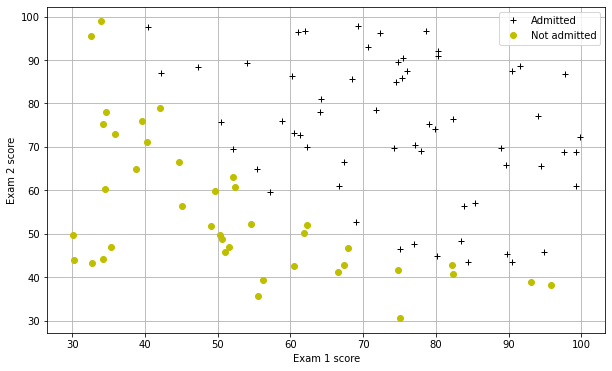

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import beta
import math

datafile = 'data/ex2data1.txt'
#!head $datafile
cols = np.loadtxt(datafile, delimiter=',', usecols=(0, 1, 2), unpack=True)  #Read in comma separated data
##Form the usual "X" matrix and "y" vector
X = np.transpose(np.array(cols[:-1]))
y = np.transpose(np.array(cols[-1:]))
m = y.size  # number of training examples
##Insert the usual column of 1's into the "X" matrix
X = np.insert(X, 0, 1, axis=1)

#Divide the sample into two: ones with positive classification, one with null classification
pos = np.array([X[i] for i in range(X.shape[0]) if y[i] == 1])
neg = np.array([X[i] for i in range(X.shape[0]) if y[i] == 0])

def plotData():
    plt.figure(figsize=(10, 6))
    plt.plot(pos[:, 1], pos[:, 2], 'k+', label='Admitted')
    plt.plot(neg[:, 1], neg[:, 2], 'yo', label='Not admitted')
    plt.xlabel('Exam 1 score')
    plt.ylabel('Exam 2 score')
    plt.legend()
    plt.grid(True)

plotData()


Implement the LDA classifier by completing the code below.

### 1.3 Centering the data [5 pts]
As an implementation detail, you should first center the positive and negative data separately, so that each set has a mean equal to [0, 0], before computing the covariance, as this tends to give a more accurate estimate of the covariance.

In [2]:
# IMPLEMENT THIS
pos_mean = np.mean(pos, axis=0)
neg_mean = np.mean(neg, axis=0)
print(pos_mean)
pos_data = pos - (pos_mean + neg_mean) / 2
neg_data = neg - (pos_mean + neg_mean) / 2


[ 1.         74.7189227  73.95640208]


### 1.4 Computing parameters and predictions [20 pts]
Implement the LDA algorithm here in vectorized form (avoid loops). First, compute the covariance matrix, then the classifier's weights, then use the classifier to make predictions on the training data. Note, you should center the whole training data set before applying the classifier. Namely, subtract the mean value of the two classes’ means (1/2*(pos_mean+neg_mean)), which is on the separating plane when their prior probabilities are the same and becomes the ‘center’ of the data. 

In [3]:
# IMPLEMENT THIS
cov_all = np.cov(pos_data.T[1:]) + np.cov(neg_data.T[1:]) # SHAPE: (2,2)
print(cov_all.shape)

w = np.linalg.inv(cov_all)@(pos_mean[1:] - neg_mean[1:])
print(w)

y_lda = np.concatenate((neg_data, pos_data),axis=0)[:,1:]@w  # SHAPE: (100,)
print(y_lda.shape)

(2, 2)
[0.0785182  0.07571361]
(100,)


### 1.5 Training accuracy [5 pts]
Complete the code to compute the training set accuracy, which should be around 89%.  

In [4]:
# IMPLEMENT THIS
pred = [0 for i in range(m)]
count = 0

for i in range(m):
    if y_lda[i] > 0:
        pred[i] = 1
    if y_lda[i] < 0:
        pred[i] = 0

for i in range(m):
    if pred[i] == np.sort(y,axis=0)[i]:
        count += 1
accuracy = count / m

print(accuracy)

0.89


### 1.6 Bonus [10 pts] (optional)
As an optional bonus exercise, try changing the prior probability of the positive class $P(y = 1) = \pi$ and show how the resulting decision boundary changes by plotting it. What is the effect of changing $\pi$ on the boundary?

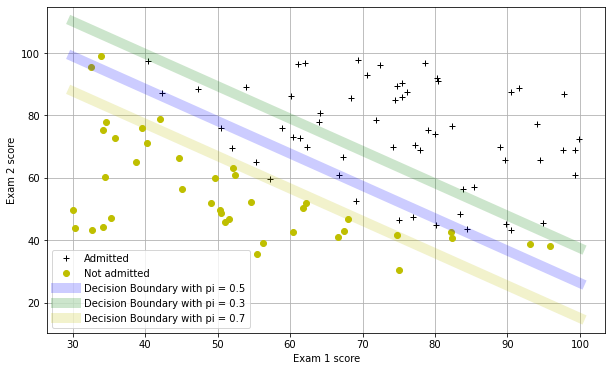

In [5]:
# IMPLEMENT THIS
pi_1 = 0.3
w_01 = math.log (pi_1 / (1 - pi_1))
pi_2 = 0.7
w_02 = math.log (pi_2 / (1 - pi_2))

xx = np.linspace(30,100,10)
yy = -(w[0]/w[1])*xx + (w[0]/w[1])*((pos_mean+neg_mean)/2)[1] + ((pos_mean+neg_mean)/2)[2]
yy_7 = -(w[0]/w[1])*xx + (w[0]/w[1])*((pos_mean+neg_mean)/2)[1] + ((pos_mean+neg_mean)/2)[2] - w_02 / w[1]
yy_3 = -(w[0]/w[1])*xx + (w[0]/w[1])*((pos_mean+neg_mean)/2)[1] + ((pos_mean+neg_mean)/2)[2] - w_01 / w[1]

plotData()
plt.plot(xx, yy, 'b-', lw=10, alpha=0.2, label='Decision Boundary with pi = 0.5')   
plt.plot(xx, yy_3, 'g', lw=10, alpha=0.2, label='Decision Boundary with pi = 0.3')   
plt.plot(xx, yy_7, 'y', lw=10, alpha=0.2, label='Decision Boundary with pi = 0.7')   
plt.legend()
plt.show()

As the above figure shows, the value of $\pi$ only affects the intercept of the decision boundary. When $\pi$ increases, the decision boundary will move lower, making more people being classified as admitted, since $\pi$ represents the prior probability of the positive class.

## 2 Conjugate Prior [25 pts]

In this problem we will estimate the parameter $\theta$ of the coin flipping problem using the Bayesian approach. In the Bayesian approach, $\theta$ is considered a random variable sampled from some prior distribution $p(\theta)$. We represent the ith coin flip by a Bernoulli random variable $x ∈ \{0, 1\}$, where $x_i = 1$ if the ith flip lands on heads. We assume that the observed $x_i$’s are conditionally indendent given $\theta$. This means that the joint distribution of $n$ coin flips and $\theta$ can be factorized as

$$ p(x_1,...,x_n,\theta) = p(\theta) \prod_{i=1}^{n} p(x_i|\theta)  $$

Suppose that our prior distribution on $\theta$ is $Beta(h, t)$, for some $h, t > 0$. That is, 

$$p(\theta) \propto \theta^{h-1}(1-\theta)^{t-1}$$ 

See Bishop Ch 2.1.1 or https://en.wikipedia.org/wiki/Beta_distribution for more details on this distribution. There is a nice online graphing tool here http://eurekastatistics.com/beta-distribution-pdf-grapher/.

The Beta distribution is a conjugate to the Bernoulli distribution since the prior $p(\theta)$ and posterior $p(\theta|x_1,...,x_n)$  are in the same family (the Beta family). 

### 2.1 Posterior [10 pts]
Suppose our dataset of flips has $H$ heads and $T$ tails. Show that the posterior distribution fo $\theta$ is $Beta(h+H, t+T)$, i.e. show that

$$ p(\theta|x_1,...,x_n) \propto \theta^{h-1+H}(1-\theta)^{t-1+T} $$


**Answer:** 

Given that the prior distribution on $\theta$ is $Beta(h,t)$(Prior):
$$
P(\theta) = \frac{\tau(h+t)}{\tau(h)\tau(t)} \theta^{h-1} (1-\theta)^{t-1} = \frac{\theta^{h-1} (1-\theta)^{t-1}}{B(h,t)}
$$

And the dataset of flips has H heads and T tails(Likelihood):
$$
P(h,t|\theta) = Binomial(H+T, \theta) = {(H+T) \choose H} \theta^H (1-\theta)^T
$$

Therefore, the posterior distribution on $\theta$ can be written as:

$$
P(\theta | h,t) = \frac{P(h,t | \theta)P(\theta)}{ \int P(h,t | y)P(y) dy } 
= \frac{ {(H+T) \choose H} \theta^{h-1+H} (1-\theta)^{t-1+T} / B(h,t)} {\int_{y=0}^1 \{{(H+T) \choose H} y^{h-1+H} (1-y)^{t-1+T} / B(h,t)\} dy}
= \frac{\theta^{h-1+H} (1-\theta)^{t-1+T}}{B(h+H,t+T)}
$$

,which means the posterior distribution of $\theta$ is $Beta(h+H,t+T)$.

### 2.2 Parameter estimates [10 pts]
Give the expressions for three estimates of $\theta$: the Maximum Likelihood ($\theta_{ML}$), the Maximum a Posteriori ($\theta_{MAP}$) or the mode of the posterior over $\theta$, and the mean of the posterior ($\theta_{MP}$).

*Hint:*
You may use the fact that a Beta(h, t) distribution has mean $h/(h + t)$ and has mode $(h − 1) / (h + t − 2)$ for $h, t > 1$. 


**Answer:**
According to the maximum likelihood, with H heads and T tails
$$
\theta_{ML} = \mathop{\arg\max}_{\theta} \{log\ P(D | \theta)\} = \mathop{\arg\max}_{\theta}\{log (\theta^H (1-\theta)^T )\}
$$
Set the derivative on $\theta$ to 0:
$$
\frac{\partial}{\partial \theta}log\ P(D | \theta) = \theta^{H-1}(1-\theta)^{T-1}(H - H\theta - T\theta) = 0
$$
Therefore, we have: 
$$
\theta_{ML} = \frac{H}{H+T}
$$

According to 2.1, the posterior distribution on $\theta$ is $Beta(h+H,t+T)$, we have:
$$
\theta_{MAP} = \frac{h+H-1}{h+H+t+T-2} \\
\theta_{MP} = \frac{h+H}{h+H+t+T}
$$



### 2.3 Example [5 pts]
Supose you are modeling some event with a binary outcome (such as a user clicking on an ad after viewing it). You know that typical fractions of positive events observed in data are between 0.01 and 0.02. What are reasonable hyperparameters of the Beta prior to use, and why? Include a plot of the resulting prior PDF.

**Answer:**

Given that the typical fractions of positive events observed are between 0.01 and 0.02, we can assume that the fraction is the mean(which is 0.015). Therefore, the fraction of positive and negative is $\frac{0.015}{0.985} = \frac{3}{197}$. Then the hyperparameters of the Beta prior is 3 and 197, and the prior distribution is $Beta(3,197)$, which is shown below.

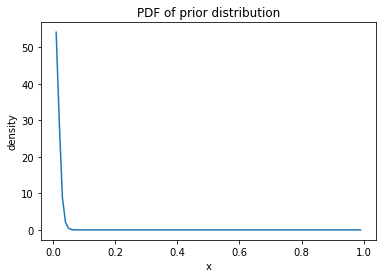

In [6]:
a = 3
b = 197
x = np.arange(0.01,1,0.01)
y = beta.pdf(x,a,b)
plt.plot(x,y)
plt.title('PDF of prior distribution')
plt.xlabel('x')
plt.ylabel('density')
plt.show()

## 3 Bayesian Linear Regression [25 pts + 10pts bonus]
In this exercise, we implement Bayesian regression with linear basis function models. Recall that a linear regression model $y$(**x**,**w**) can be defined more generally as

$$y(\textbf{x},\textbf{w}) = w_0 + \sum_{j=1}^{M-1} w_j \phi_j (\textbf{x}) = \sum_{j=0}^{M-1} w_j \phi_j (\textbf{x}) = \textbf{w}^T \phi(\textbf{x})$$

where $\phi_j$ are basis functions and $M$ is the total number of parameters $w_j$ including the bias term $w_0$.
The target variable $t$ of an observation $\textbf{x}$ is given by a deterministic function $y(\textbf{x}, \textbf{w})$ plus additive random noise $\epsilon$.

$$t = y(\textbf{x}, \textbf{w}) + \epsilon $$

We assume that the noise is normally distributed i.e. follows a Gaussian distribution with zero mean and precision (inverse variance) $\beta$. The corresponding probabilistic model i.e. the conditional distribution of $t$ given $\textbf{x}$ can therefore be written as

$$p(t|\textbf{x},\textbf{w},\beta) = \mathcal{N}(t|y(\textbf{x}, \textbf{w}), \beta^{-1}) = \sqrt{\frac{\beta}{2\pi}} \text{exp}\left(-\frac{\beta}{2}(t - y(\textbf{x},\textbf{w}))^2\right)$$

where the mean of this distribution is the regression function $y(\textbf{x}, \textbf{w})$.

### 3.1 Posterior and posterior predictive distribution [10 pts]
For a Bayesian treatment of linear regression, we need a prior probability distribution over the model parameters $\textbf{w}$ with zero mean:

$$p(\textbf{w} | \alpha) = \mathcal{N}(\textbf{w}|0,\alpha^{-1} \textbf{I})$$

where $\alpha^{-1}I$ is the diagonal covariance matrix where all diagonal elements have the same variance $\alpha^{-1}$.


The posterior distribution has the following mean and inverse covariance matrix:

$$m_N = \beta \textbf{S}_N \Phi^T \textbf{t}$$
$$\textbf{S}^{-1}_N = \alpha \textbf{I} + \beta \Phi^{T} \Phi$$

Hence, the posterior distribution can be written as
$$p(\textbf{w}|\textbf{t},\alpha,\beta) = \mathcal{N}(\textbf{w}|\textbf{m}_N, \textbf{S}_N)$$

For making a prediction $t$ at a new location $\textbf{x}$ we use the posterior predictive distribution which is defined as

$$p(t|\textbf{t},\textbf{w},\alpha,\beta) = \int p(t|\textbf{x},\textbf{w},\beta) p(\textbf{w}|\textbf{t},\alpha,\beta) d\textbf{w}$$


Implement the posterior and posterior predictive distributions.

In [7]:
import numpy as np

def posterior(Phi, t, alpha, beta, return_inverse=False):
    """Computes mean and covariance matrix of the posterior distribution."""
    I = np.eye(Phi.shape[1])
    S_N_inv = alpha*I + beta*(Phi.T)@Phi  
    S_N = np.linalg.inv(S_N_inv)
    m_N = beta*S_N@Phi.T@t


    if return_inverse:
        return m_N, S_N, S_N_inv
    else:
        return m_N, S_N


def posterior_predictive(Phi_test, m_N, S_N, beta):
    """Computes mean and variances of the posterior predictive distribution."""

    y = m_N.T @ Phi_test.T
    y_var = np.diag((1 / beta + Phi_test @ S_N @ Phi_test.T))

    return y, y_var

### 3.2 Generating the data [5 pts]
Target values $\textbf{t}$ are generated from the design matrix **X** $\in \mathbb{R}^{N\times 1}$ with a linear function $f$ which can also generate random noise of specified variance. Implement $f$ below.

In [8]:
w0 = -0.3
w1 =  0.5

def f(X, noise_variance):
    '''Linear function plus noise'''
    return (w0 + w1*X + noise(X.shape, noise_variance))

def noise(size, variance):
    return np.random.normal(scale=np.sqrt(variance), size=size)

### 3.3 Basis functions [5 pts]
For straight line fitting, we do not need to transform $x$ with a basis function, which is equivalent to using an identity basis function. Other basis functions that are non-linear are necessary to model the non-linear relationship between input $x$ and target $t$. Below is an example of non-linear basis functions: the polynomial. Implement the polynomial basis function.
*Note: You will not use it in the rest of the exercise but your implementation should be reasonable.*

In [9]:
def identity_basis_function(x):
    return x

def polynomial_basis_function(x, power):
    return x**power

def expand(x, bf, bf_args=None):
    if bf_args is None:
        return np.concatenate([np.ones(x.shape), bf(x)], axis=1)
    else:
        return np.concatenate([np.ones(x.shape)] + [bf(x, bf_arg) for bf_arg in bf_args], axis=1)

### 3.3 Straight line fitting [5 pts]
For straight line fitting, we use a linear regression model of the form $y(\textbf{w},\textbf{x}) = w_0 + w_1 x$ and perform Bayesian inference for model parameters $\textbf{w}$. Predictions are made with the posterior predictive distribution. Since this model has only two parameters, $w_0$ and $w_1$, we can visualize the posterior density in 2D which is done in the first column of the following output. Rows use an increasing number of training data from a training dataset.

How does the dataset size affect the posterior density in the first column of the plots?

**Answer:**

In [10]:
from scipy import stats
import matplotlib.pyplot as plt

def plot_data(x, t):
    plt.scatter(x, t, marker='o', c="k", s=20)


def plot_truth(x, y, label='Truth'):
    plt.plot(x, y, 'k--', label=label)


def plot_predictive(x, y, std, y_label='Prediction', std_label='Uncertainty', plot_xy_labels=True):
    y = y.ravel()
    std = std.ravel()

    plt.plot(x, y, label=y_label)
    plt.fill_between(x.ravel(), y + std, y - std, alpha = 0.5, label=std_label)

    if plot_xy_labels:
        plt.xlabel('x')
        plt.ylabel('y')


def plot_posterior_samples(x, ys, plot_xy_labels=True):
    plt.plot(x, ys[:, 0], 'r-', alpha=0.5, label='Post. samples')
    for i in range(1, ys.shape[1]):
        plt.plot(x, ys[:, i], 'r-', alpha=0.5)

    if plot_xy_labels:
        plt.xlabel('x')
        plt.ylabel('y')


def plot_posterior(mean, cov, w0, w1):
    resolution = 100

    grid_x = grid_y = np.linspace(-1, 1, resolution)
    grid_flat = np.dstack(np.meshgrid(grid_x, grid_y)).reshape(-1, 2)

    densities = stats.multivariate_normal.pdf(grid_flat, mean=mean.ravel(), cov=cov).reshape(resolution, resolution)
    plt.imshow(densities, origin='lower', extent=(-1, 1, -1, 1))
    plt.scatter(w0, w1, marker='x', c="r", s=20, label='Truth')

    plt.xlabel('w0')
    plt.ylabel('w1')


def print_comparison(title, a, b, a_prefix='np', b_prefix='br'):
    print(title)
    print('-' * len(title))
    print(f'{a_prefix}:', a)
    print(f'{b_prefix}:', b)
    print()

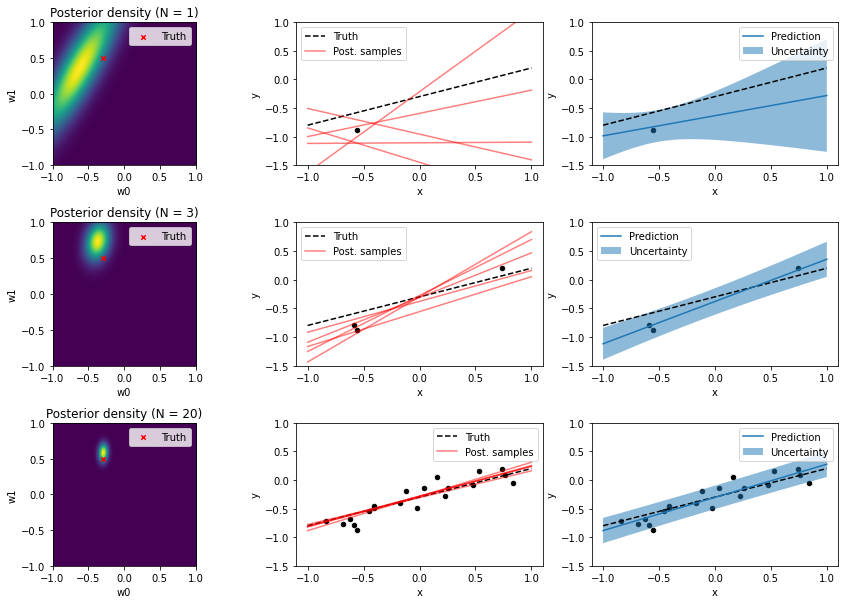

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

# fix random seed so we always get the same data
np.random.seed(5)

# Training dataset sizes
N_list = [1, 3, 20]

beta = 25.0
alpha = 2.0

# Training observations in [-1, 1)
X = np.random.rand(N_list[-1], 1) * 2 - 1

# Training target values
t = f(X, noise_variance=1/beta)

# Test observations
X_test = np.linspace(-1, 1, 100).reshape(-1, 1)

# Function values without noise 
y_true = f(X_test, noise_variance=0)
    
# Design matrix of test observations
Phi_test = expand(X_test, identity_basis_function)

plt.figure(figsize=(15, 10))
plt.subplots_adjust(hspace=0.4)

for i, N in enumerate(N_list):
    X_N = X[:N]
    t_N = t[:N]

    # Design matrix of training observations
    Phi_N = expand(X_N, identity_basis_function)
    
    # Mean and covariance matrix of posterior
    m_N, S_N = posterior(Phi_N, t_N, alpha, beta)
    
    # Mean and variances of posterior predictive 
    y, y_var = posterior_predictive(Phi_test, m_N, S_N, beta)
    
    # Draw 5 random weight samples from posterior and compute y values
    w_samples = np.random.multivariate_normal(m_N.ravel(), S_N, 5).T
    y_samples = Phi_test.dot(w_samples)
    
    plt.subplot(len(N_list), 3, i * 3 + 1)
    plot_posterior(m_N, S_N, w0, w1)
    plt.title(f'Posterior density (N = {N})')
    plt.legend()

    plt.subplot(len(N_list), 3, i * 3 + 2)
    plot_data(X_N, t_N)
    plot_truth(X_test, y_true)
    plot_posterior_samples(X_test, y_samples)
    plt.ylim(-1.5, 1.0)
    plt.legend()

    plt.subplot(len(N_list), 3, i * 3 + 3)
    plot_data(X_N, t_N)
    plot_truth(X_test, y_true, label=None)
    plot_predictive(X_test, y, np.sqrt(y_var))
    plt.ylim(-1.5, 1.0)
    plt.legend()

### 3.4 Bonus [10 pts] (optional)
We now fit a Gaussian basis function model to a noisy sinusoidal dataset for which we provide a sinusoidal function $g$ with noise variance. Implement the gaussian basis function below.

The model uses 7 Gaussian basis functions with mean values equally distributed over [0,1] each having a standard deviation of 0.1. We then infer the model parameters **w** using the posterior predictive distribution.

How many parameters $w_i$ are there? Run Bayesian inference and generate the plots. Do they follow the same trend as the ones generated by Bayesian linear regression?

**Answer:**

In [12]:
def g(X, noise_variance):
    '''Sinusoidial function plus noise'''
    return 0.5 + np.sin(2 * np.pi * X) + noise(X.shape, noise_variance)


def gaussian_basis_function(x, mu, sigma=0.1):
    return np.exp(-(x-mu)*(x-mu) / (2*sigma**2))

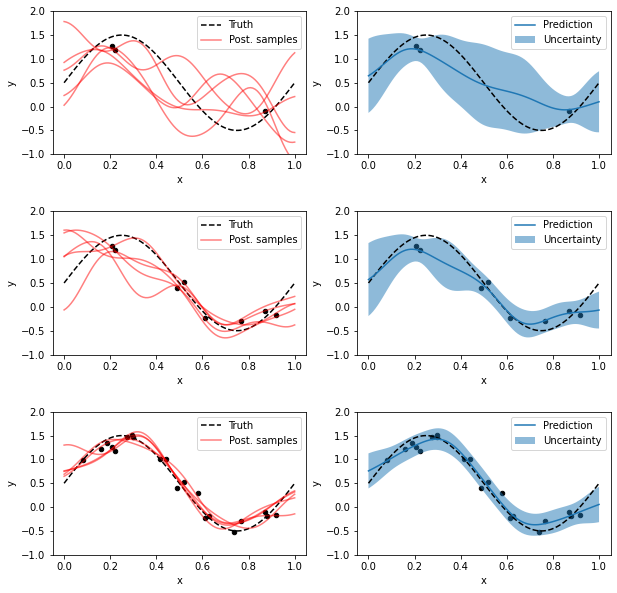

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import curve_fit

# fix random seed so we always get the same data
np.random.seed(5)

N_list = [3, 8, 20]

beta = 25.0
alpha = 2.0

# Training observations in [-1, 1)
X = np.random.rand(N_list[-1], 1)

# Training target values
t = g(X, noise_variance=1/beta)

# Test observations
X_test = np.linspace(0, 1, 100).reshape(-1, 1)

# Function values without noise 
y_true = g(X_test, noise_variance=0)
    
# Design matrix of test observations
Phi_test = expand(X_test, bf=gaussian_basis_function, bf_args=np.linspace(0, 1, 7))

plt.figure(figsize=(10, 10))
plt.subplots_adjust(hspace=0.4)

for i, N in enumerate(N_list):
    X_N = X[:N]
    t_N = t[:N]

    # Design matrix of training observations
    Phi_N = expand(X_N, bf=gaussian_basis_function, bf_args=np.linspace(0, 1, 7))

    # Mean and covariance matrix of posterior
    m_N, S_N = posterior(Phi_N, t_N, alpha, beta)
    
    # Mean and variances of posterior predictive 
    y, y_var = posterior_predictive(Phi_test, m_N, S_N, beta)
    
    # Draw 5 random weight samples from posterior and compute y values
    w_samples = np.random.multivariate_normal(m_N.ravel(), S_N, 5).T
    y_samples = Phi_test.dot(w_samples)
    
    plt.subplot(len(N_list), 2, i * 2 + 1)
    plot_data(X_N, t_N)
    plot_truth(X_test, y_true)
    plot_posterior_samples(X_test, y_samples)
    plt.ylim(-1.0, 2.0)
    plt.legend()
    
    plt.subplot(len(N_list), 2, i * 2 + 2)
    plot_data(X_N, t_N)
    plot_truth(X_test, y_true, label=None)
    plot_predictive(X_test, y, np.sqrt(y_var))
    plt.ylim(-1.0, 2.0)
    plt.legend()